## <center> Structural Analysis and Visualization of Networks</center>


## <center>Home Assignment #4: Community Detection Algorithms

### <center>Student: *Manokhina Anastasia*</center>

#### <hr /> General Information

**Due Date:** 03.04.2016 23:59 <br \>
**Late submission policy:** the task will not be graded! <br \>


Please send your reports to <network.hse.2016@gmail.com> with message subject of the following structure:<br \> **[HSE Networks 2015] *{LastName}* *{First Name}* HA*{Number}***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<br \>
<hr \>

## Problems

### Task 1* (For those who have not done that during the seminar)

On this seminar your are asked to implement simple community detection algorightm. It is called [Markov Cluster Algorithm](http://micans.org/mcl/) (MCL).

Implement Markov Clustering Algorithm

**Input:** Transition matrix $T = D^{-1}A$

**Output:** Adjacency matrix $M^*$

1. Set $M = T$
2. **repeat:**
    3. *Expansion Step:* $M = M^p$ (usually $p=2$)
    4. *Inflation Step:* Raise every entry of $M$ to the power $\alpha$ (usualy $\alpha=2$)
    5. *Renormalize:* Normalize each row by its sum
    6. *Prunning:* Replace entries that are close to $0$ by pure $0$
7. **until** $M$ converges
8. $M^* = M$
<br\>
<br\>

As a result you should get a cluster matrix s.t. elements of the cluster correspond to nonzero elements of the columns of the matrix. 
<br\>
* Run this method for network [1](https://www.hse.ru/data/2016/03/15/1127695811/network1.mat), [2](https://www.hse.ru/data/2016/03/15/1127699956/network2.mat) and [3](https://www.hse.ru/data/2016/03/15/1127703057/network3.mat).
* Play with the parameters ($p$, $\alpha$, zero tolerance), analyse the results

<hr />


Importing modules and downloading the data:

In [85]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

network1 = scipy.io.loadmat('network1.mat')
network2 = scipy.io.loadmat('network2.mat')
network3 = scipy.io.loadmat('network3.mat')

Forming acceptable data format for adjacency matrices:

In [87]:
matrix1 = network1.values()[0].astype('float64')
matrix2 = network2.values()[0].astype('float64')
matrix3 = network3.values()[0].astype('float64')

Implementing the algorithm:

In [146]:
import numpy as np

def MCL(A, p, alpha, tol):
    step = 1
    col_sums = A.sum(axis = 0)
    T = A / col_sums[np.newaxis, :]
    M = T
    while(1):
        step += 1
        M1 = np.linalg.matrix_power(M, p)
        M1 = np.power(M1, alpha)        
        col_sums = M1.sum(axis = 0)
        M1 = M1 / col_sums[np.newaxis, :]
        M1[M1<=tol] = 0
        if np.linalg.norm(M - M1) == 0:            
            return M1
        else:
            M = M1

Let's set function parameters to some values and look at the results:

In [145]:
p = 5 
alpha = 5  
tol = 0.01 

In [147]:
M1 = MCL(matrix1, p, alpha, tol) #5, 5, .01
M2 = MCL(matrix2, p, alpha, tol) 
M3 = MCL(matrix3, p, alpha, tol) 

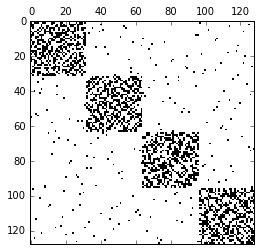

In [88]:
plt.spy(matrix1)

This is a comparison of how an adjacency matrix looks before (above) and after going through the algorithm:

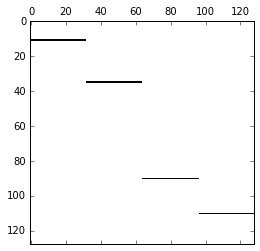

In [151]:
plt.spy(M1)

This visualization shows how algorithm splits all the nodes in graph into communities (here we have 4).

Let's look at other networks.

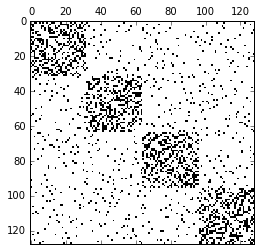

In [152]:
plt.spy(matrix2)

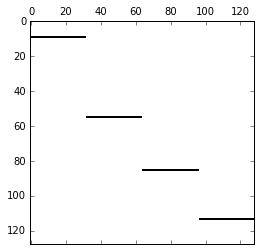

In [153]:
plt.spy(M2)

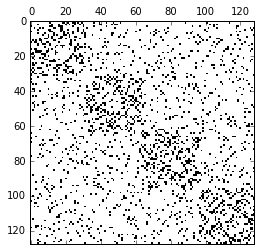

In [154]:
plt.spy(matrix3)

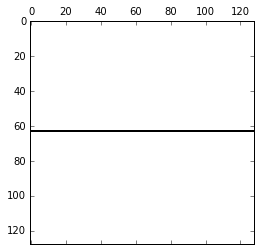

In [156]:
plt.spy(M3)

As we see on the plot of source matrix, only one (or a very small number of nodes) has connections with all the rest of the nodes and is likely to be the 'center' of the community. It can be true, because by spy plot of adjacency matrix we can see that there are no such clear clusters. Anyway, let's play with parameters to see if it's gonna change.

Let's try another set of parameter values:

In [158]:
p = 3 
alpha = 3  
tol = 0.01 

In [159]:
M11 = MCL(matrix1, p, alpha, tol) #3, 3, .01
M22 = MCL(matrix2, p, alpha, tol) 
M33 = MCL(matrix3, p, alpha, tol) 

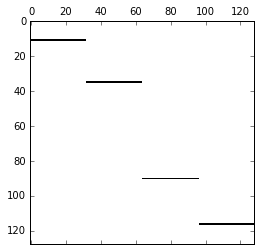

In [160]:
plt.spy(M11)

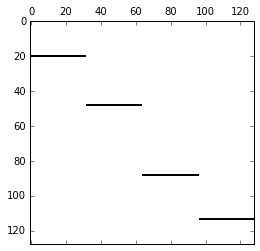

In [161]:
plt.spy(M22)

In two first networks results are the same, they are quite stable as communities are clearly determined there. That we cannot say about the third one:

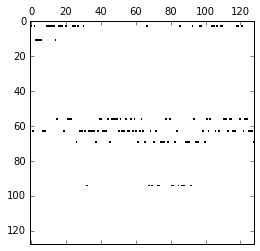

In [162]:
plt.spy(M33)

Only few nodes keep connections here, and not so much connections. So we can say it is a network of somehow isolated nodes. Let's try another parameter set for last network:

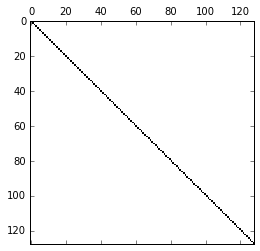

In [174]:
M333 = MCL(matrix3, 2, 2, 0.1) 
plt.spy(M333)

This parameter set made all the nodes (almost) completely isolated. Another different sets of parameters showed one of three scenarios for this network, all of them are shown above. This strange behaviour tells us that communities in this network are determined really weakly.

### Task 2

Load [Yahoo Music network](https://www.hse.ru/data/2016/03/15/1127704844/music_data.mat). Edges in this network appear if enough number of users have given ratings to both music bands. Note, that edges are weighted with similarity of the ratings.

* Implement *multilevel spectral recursive partitioning* algorithm that was described during the lecture
* Visualize community structure of the network and output some of the dense clusters (with interpretation, if you can)

You can load .mat files with the following commands:

In [1]:
import scipy.io
import networkx as nx
import pandas as pd
data = scipy.io.loadmat('music_data.mat')

In [2]:
for key, val in data.items():
    print key, type(val)

A <class 'scipy.sparse.csc.csc_matrix'>
__version__ <type 'str'>
artists <type 'numpy.ndarray'>
__header__ <type 'str'>
__globals__ <type 'list'>


In [3]:
matrix = data.values()[0]
artists = data.values()[2]

Constructing a graph object and its attributes (names of artists):

In [6]:
music_graph = nx.from_scipy_sparse_matrix(data.values()[0])
nx.set_node_attributes(music_graph, 'artist', list(pd.DataFrame(artists)[:][0]))

Unfortunately my machine refused to visualize 9k nodes network:

nx.draw(music_graph)

Implementing the algorithm. It recursively divides the graph based on adjacency matrix by means of linear algebra magic: it computes the eigenvector corresponding to second smallest eigenvalue of matrix L, and denotes different communities for nodes who received different signs of corresponding component of observed eigenvector.

I decided to make a restriction of 200 nodes for stopping the dividing.

In [76]:
import numpy as np
from scipy.sparse import csc_matrix, linalg

def msrpa(A):
        G = nx.from_scipy_sparse_matrix(A)
        D = csc_matrix(np.diag(G.degree(G.nodes()).values()))
        L = D - A
        w, v = linalg.eigsh(L, k=2, which = 'SM')
        s = np.sign(v[:,1])
        index1 = np.where(s>0)[0]
        index0 = np.where(s<0)[0]
        a = A.todense()
        set1 = a[index1,][:,index1]
        set0 = a[index0,][:,index0]
        if set1.shape[0]<200:
            return set1
        else:
            msrpa(csc_matrix(set1))
        if set0.shape[0]<200:
            return set0
        else:
            msrpa(csc_matrix(set0))


In [83]:
msrpa(matrix)

Unfortunately, due to some hardware problems I couldn't visualize observed communities. I guess the communities in music network are correlated with music genres -- similar bands should be in the same communities of network.